In [1]:
import pandas as pd
from matplotlib.patches import Patch
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import re
import matplotlib as mpl
from itertools import product
import seaborn as sns
import glob
import pickle
import os
from pycsca.csv_reader import CSVReader
from pycsca.plot_utils import plot_importance, learning_curve_for_label, fig_param, custom_dict, colors
from pycsca.utils import progress_bar
import math

In [15]:
x = ['a', 'b', 'b', 'c', 'c', 'c']
i, c = np.unique(x, return_counts=True)
dict(zip(i,c))

{'a': 1, 'b': 2, 'c': 3}

In [2]:
colors = ['black', 'blueviolet', 'mediumorchid', 'plum', 'mediumblue', 'firebrick',
          'darkorange', 'sandybrown','darkgoldenrod', 'gold', 'khaki']
def bar_grid_for_dataset(dirname1, title1, dirname2, title2, metric1, metric2, std, 
                         figsize, dataset1, output_filename):
    def get_df(dirname):
        file_path = os.path.join(dirname, 'Model Results.csv')
        data_frame = pd.read_csv(file_path, index_col=0)
        data_frame['rank'] = data_frame['Model'].map(custom_dict)
        data_frame.sort_values(by=['Dataset', 'rank'], ascending=[True, True], inplace=True)
        del data_frame['rank']
        return data_frame
    df1, df2 = get_df(dirname1), get_df(dirname2)
    sns.set(color_codes=True)
    plt.style.use('default')
    rcParams['font.family'] = 'serif'
    fontsize = 10
    rcParams['font.size'] = fontsize
    bar_width = 0.4
    opacity = 1.0
    offset = 0.1
    df1 = df1[~df1['Dataset'].str.contains('Multi-Class')]
    df2 = df2[~df2['Dataset'].str.contains('Multi-Class')]
    df1 = df1[~df1['Model'].str.contains('SGD')]
    df2 = df2[~df2['Model'].str.contains('SGD')]
    u_models = list(df1.Model.unique())
    u_models = [model.split('Classifier')[0] for model in u_models]
    u_models[u_models.index('Perceptron')] = "PerceptronLearningAlgorithm"
    #u_models[u_models.index('SGD')] = "StochasticGradientDescent"
    if 'SVC' in u_models:
        u_models[u_models.index('SVC')] = "SupportVectorMachine"
    else:
        u_models[u_models.index('LinearSVC')] = "SupportVectorMachine"
    u_models[u_models.index('Ridge')] = "RidgeClassifier"
    u_models[u_models.index('HistGradientBoosting')] = "HistogramGradientBoosting"
    u_models[0] = 'RandomGuesser'
    #u_models = ['\n'.join(re.findall('[A-Z][^A-Z]*', model)) for model in u_models]
    u_models = [' '.join(re.findall('[A-Z][^A-Z]*', model)) for model in u_models]
    #u_models[u_models.index('Histogram Gradient Boosting')] = "Histogram\nGradient Boosting"
    #u_models[u_models.index('Stochastic Gradient Descent')] = "Stochastic Gradient\nDescent"
    #u_models[u_models.index('Support Vector Machine')] = "Support Vector\nMachine"
    import string
    #u_models = [re.sub('[a-z]', '', model) for model in u_models]


    u_datasets = list(df1.Dataset.unique())
    bar_width_offset = bar_width + offset
    space = 0.2
    index = []
    for i in [1,3,1,1,2,3]:
        if len(index)==0:
            index.extend(list(np.arange(1, i+1) * bar_width_offset))
        else:
            ll = (index[-1] + space) + (np.arange(1, i+1) * bar_width_offset)
            index.extend(ll)
    # j = 0
            
    ini = index[0]
    u_datasets.sort()

    for dataset in u_datasets[0::2]:
        print(dataset)
        if not (dataset1 in dataset):
            continue
        #fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7 , ax8)) = plt.subplots(nrows=2, ncols=4, figsize=figsize, frameon=True, edgecolor='k')
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize, frameon=True, edgecolor='k', sharey='row')
        axs = np.array(axs).flatten()
        def plot_ax(ax, df, title, metric):
            if 'pval' in metric:
                end = 0.011
                step = 2e-3
                round1 = 5
            else:
                end = 1.1
                step = 0.25
                round1 = 2
            accs = np.array(df[df['Dataset'] == dataset][metric].values)

            if metric == "Accuracy" or metric == "F1-Score":
                #ax.plot([ini - bar_width / 2, index[-1] + bar_width / 2 + offset], [0.5, 0.5], "k",alpha=0.5, linewidth=0.5)
                ax.axhline(0.5, color='black', xmin=0.05, xmax=0.94, linewidth=1, zorder=-1)
                ax.text(index[-1]+bar_width-0.1, 0.43, s='$0.5$', fontsize=fontsize, color='darkgreen')
                #errors = list(df[df['Dataset'] == dataset][metric + '-std'].values / std)
                errors = np.zeros_like(accs)
            else: 
                errors = np.zeros_like(accs)
                for i in range(len(accs)):
                    if accs[i]==0.0:
                        accs[i] += 1e-3*np.random.rand(1)
                ax.axhline(0.01, color='black', xmin=0.05, xmax=0.94, linewidth=1, zorder=-1)
                ax.text(index[-1]+bar_width-0.1, 0.01-5e-4, s=r'$ \alpha $', fontsize=fontsize, color='darkgreen')

               #ax.plot([ini - bar_width / 2, index[-1] + bar_width / 2 + offset], [0.01, 0.01], "k")
            ax.bar(x=index, height=accs, yerr=errors, width=bar_width, alpha=opacity, color=colors)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            #ax.tick_params(axis='x', which='major')
            #ax.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xticks([])
            if metric == metric1:
                ax.set_title(title, fontsize=fontsize-2, y  = 0.9)
            else:
                import matplotlib.ticker as mticker
                f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
                g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
                #plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
            ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
            ax.set_ylim(0.0, end)
            
        plot_list =list(product([metric1, metric2], [(df1, title1), (df2, title2)]))
        for ax, (metric, (df, title)) in zip(axs, plot_list):
            plot_ax(ax, df, title, metric)
        
        if 'pval' in metric2:
            axs[2].set_ylabel('p-value')       
        axs[0].set_ylabel(metric1.title())
        #fig.suptitle('Missing CCS-FIN', x=0.51)       

        cmap = dict(zip(u_models, colors))

        # create the rectangles for the legend
        patches = [Patch(color=v, label=k) for k, v in cmap.items()]
        params = dict(loc='upper center', bbox_to_anchor=(-0.2, 0), ncol=1, fancybox=False, frameon=True,
                      shadow=False, facecolor='white', edgecolor='k', fontsize=fontsize)
        plt.legend(handles=patches, **params)
        
        plt.savefig(output_filename, bbox_inches='tight')
        plt.show()   

0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02)
0X00 In Some Padding Byte
0X00 On The Last Position  (|Pms| = 0)
0X00 On The Next To Last Position (|Pms| = 1)
Correctly Formatted Pkcs#1 Message  (|Pms| = 47)
Correctly Formatted Pkcs#1 Pms Message  But 1 Byte Shorter
Invalid Tls Version In Pms


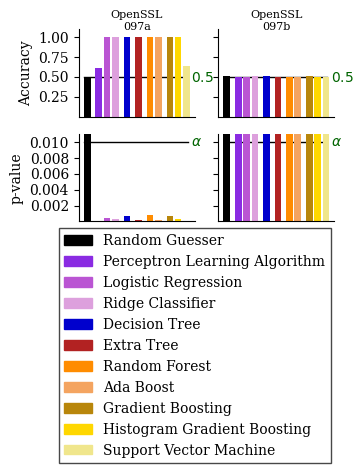

No 0X00 In Message
Wrong First Byte (0X00 Set To 0X17)
Wrong Second Byte (0X02 Set To 0X17)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline
dirname1 = os.path.join(os.getcwd(), "2021-01-06-openssl097aserver")
dirname2 = os.path.join(os.getcwd(), "2021-01-13-openssl097bserver")
output_filename = os.path.join(os.getcwd(), 'results', 'openssl097a_vs_openssl097b_accuracy.pgf')
params = [dirname1, 'OpenSSL\n097a', dirname2, 'OpenSSL\n097b', 'Accuracy', 'ttest-pval', 
          np.sqrt(30), (3.3, 2.5), 'Invalid Tls Version In Pms',output_filename]
bar_grid_for_dataset(*params)

0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02)
0X00 In Some Padding Byte
0X00 On The Last Position  (|Pms| = 0)
0X00 On The Next To Last Position (|Pms| = 1)
Correctly Formatted Pkcs#1 Message  (|Pms| = 47)
Correctly Formatted Pkcs#1 Pms Message  But 1 Byte Shorter
Invalid Tls Version In Pms
No 0X00 In Message
Wrong First Byte (0X00 Set To 0X17)


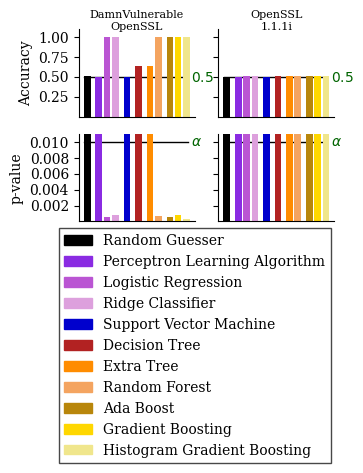

Wrong Second Byte (0X02 Set To 0X17)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline
dirname1 = os.path.join(os.getcwd(), '2021-01-14-damnvulnerableopensslserverfast')
dirname2 = os.path.join(os.getcwd(), '2021-01-14-opensslserver111i')
output_filename = os.path.join(os.getcwd(), 'results', 'openssl111g_vs_damnvulnerable_accuracy.pgf')
params = [dirname1, 'DamnVulnerable\nOpenSSL', dirname2, 'OpenSSL\n1.1.1i', 'Accuracy', 'ttest-pval', 
          np.sqrt(30), (3.3, 2.5), 'Wrong First Byte (0X00 Set To 0X17)',output_filename]
bar_grid_for_dataset(*params)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams

from matplotlib.patches import Patch
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline


def bar_grid_for_dataset1(dataframe_1, title_1, dataframe_2, title_2, dataframe_3, title_3, dataframe_4, title_4,
                          output_filename, params):
    label2 = 'Invalid Tls Version In Pms'
    label1 = 'Wrong First Byte (0X00 Set To 0X17)'
    def trans(df, label, title):
        df['rank'] = df['Model'].map(custom_dict)
        df.sort_values(by=['Dataset', 'rank'], ascending=[True, True], inplace=True)
        del df['rank']
        df = df[~df['Model'].str.contains('SGD')]
        df = df[df.Dataset.eq(label)]
        title = title
        #+ '\n'.join(label.split(' ')[:2])+'\n'.join(label.split(' ')[2:])
        #print('\n'.join(label.split(' ')[:2]), '\n'.join(label.split(' ')[2:]))
        return df, title
    df1,title_1 = trans(dataframe_1, label1, title_1)
    df2, title_2 = trans(dataframe_2, label1, title_2)
    df3, title_3 = trans(dataframe_3, label2, title_3)
    df4, title_4 = trans(dataframe_4, label2, title_4)
    u_models = list(df1.Model.unique())
    # Use serif font
    rcParams['font.family'] = 'serif'
    fontsize = 10
    rcParams['font.size'] = fontsize

    # Create two subplots
    fig, (axs,axs1) = plt.subplots(2, 4, figsize=(7, 1.8), sharey='row')

    # Calculate bar locations
    bar_x_positions = []
    bar_width = 0.5
    offset = 0.1
    space = 0.3
    bar_width_offset = bar_width + offset
    for i in [1, 3, 1, 1, 2, 3]:
        if len(bar_x_positions) == 0:
            bar_x_positions.extend(list(np.arange(1, i + 1) * bar_width_offset))
        else:
            ll = (bar_x_positions[-1] + space) + (np.arange(1, i + 1) * bar_width_offset)
            bar_x_positions.extend(ll)

    # Plot the data as bars
    
    for df,ax,ax1 in zip([df1, df2, df3, df4], axs, axs1):
        ax.bar(x=bar_x_positions, height=df.Accuracy, width=bar_width, color=colors, linewidth=0)
        ax1.bar(x=bar_x_positions, height=df['ttest-pval'], width=bar_width, color=colors, linewidth=0)

    u_models = [model.split('Classifier')[0] for model in u_models]
    #u_models[u_models.index('SGD')] = "StochasticGradientDescent"
    if 'LinearSVC' in u_models:
        u_models[u_models.index('LinearSVC')] = "SupportVectorMachine"
    else:
        u_models[u_models.index('SVC')] = "SupportVectorMachine"

    u_models = [model.split('Classifier')[0] for model in u_models]

    u_models[u_models.index('Ridge')] = "RidgeClassifier"
    u_models[u_models.index('HistGradientBoosting')] = "HistogramGradientBoosting"
    u_models[0] = 'RandomGuesser'
    
    u_models = [' '.join(re.findall('[A-Z][^A-Z]*', model)) for model in u_models]
    u_models[u_models.index('Perceptron')] = "Perceptron Learning\nAlgorithm"
    u_models[u_models.index('Histogram Gradient Boosting')] = "Histogram\nGradient\nBoosting"
    u_models[u_models.index('Support Vector Machine')] = "Support Vector\nMachine"
    
    cmap = dict(zip(u_models, colors))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    params['fontsize']=fontsize
    plt.legend(handles=patches, **params)

    # Layout improvements
    fig.tight_layout()
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        ax.axhline(0.5, color='black', linewidth=1, zorder=-1)
        end = 1.1
        step = 0.25
        round1 = 2
        ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
        ax.set_ylim((0, end))
    
    for ax in axs1:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        ax.axhline(0.01-5e-4, color='black', linewidth=1, zorder=-1)
        end = 0.011
        step = 2e-3
        round1 = 5
        ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
        ax.set_ylim((0, end))

    #ax.text(bar_x_positions[-1]+bar_width-0.1, 0.01-5e-4, s=r'$ \alpha $', fontsize=fontsize, color='darkgreen')
    axs[0].set_title(label1)
    axs[0].set_ylabel('Accuracy')
    axs1[0].set_ylabel('p-value')       
    for ax, title in zip(axs, [title_1, title_2, title_3, title_4]):
        #title = title.replace(' ', '\n')
        ax.set_title(title, fontsize=fontsize, y  = .91)
    # Save plot to file
    fig.savefig(output_filename, bbox_inches='tight')
    if 'png' in output_filename:
        fig.show()

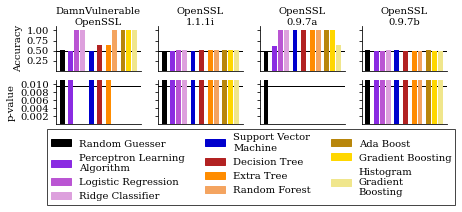

In [6]:
output_folder = os.path.join(os.getcwd(), 'results')
path = os.path.join(os.getcwd(), "2021-01-06-openssl097aserver", 'Model Results.csv')
dataframe_097a = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), "2021-01-13-openssl097bserver", 'Model Results.csv')
dataframe_097b = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-14-damnvulnerableopensslserverfast', 'Model Results.csv')
dataframe_damn = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-14-opensslserver111i', 'Model Results.csv')
dataframe_open = pd.read_csv(path, index_col=0)
params = dict(loc='upper center', bbox_to_anchor=(-1.3, 0), ncol=3, fancybox=False, frameon=True,
                      shadow=False, facecolor='white', edgecolor='k')
bar_grid_for_dataset1(dataframe_damn, 'DamnVulnerable\nOpenSSL',
                      dataframe_open, 'OpenSSL\n1.1.1i',
                      dataframe_097a, 'OpenSSL\n0.9.7a',
                      dataframe_097b, 'OpenSSL\n0.9.7b',
                     os.path.join(output_folder, 'openssl_accuracies.pgf'), params)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams

from matplotlib.patches import Patch
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline


def bar_grid_for_dataset1(dataframe_1, title_1, dataframe_2, title_2, dataframe_3, title_3, dataframe_4, title_4,
                         dataframe_5, title_5, output_filename, params):
    label1 = '0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02)'
    label2 = '0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02) Missing-CCS-FIN'
    def trans(df, label):
        df['rank'] = df['Model'].map(custom_dict)
        df.sort_values(by=['Dataset', 'rank'], ascending=[True, True], inplace=True)
        del df['rank']
        df = df[~df['Model'].str.contains('SGD')]
        df = df[df.Dataset.eq(label)]
        return df
    df1 = trans(dataframe_1, label1)
    df2 = trans(dataframe_2, label2)
    df3 = trans(dataframe_3, label2)
    df4 = trans(dataframe_4, label1)
    df5 = trans(dataframe_5, label1)
    u_models = list(df1.Model.unique())

    # Use serif font
    rcParams['font.family'] = 'serif'
    fontsize = 10
    rcParams['font.size'] = fontsize

    # Create two subplots
    fig, (axs,axs1) = plt.subplots(2, 5, figsize=(7, 2.0), sharey='row')

    # Calculate bar locations
    bar_x_positions = []
    bar_width = 0.5
    offset = 0.1
    space = 0.3
    bar_width_offset = bar_width + offset
    for i in [1, 3, 1, 1, 2, 3]:
        if len(bar_x_positions) == 0:
            bar_x_positions.extend(list(np.arange(1, i + 1) * bar_width_offset))
        else:
            ll = (bar_x_positions[-1] + space) + (np.arange(1, i + 1) * bar_width_offset)
            bar_x_positions.extend(ll)

    # Plot the data as bars
    
    for df,ax,ax1 in zip([df1, df2, df3, df4, df5], axs, axs1):
        ax.bar(x=bar_x_positions, height=df.Accuracy, width=bar_width, color=colors, linewidth=0)
        ax1.bar(x=bar_x_positions, height=df['ttest-pval'], width=bar_width, color=colors, linewidth=0)

    u_models = [model.split('Classifier')[0] for model in u_models]
    u_models[u_models.index('LinearSVC')] = "SupportVectorMachine"

    u_models[u_models.index('Ridge')] = "RidgeClassifier"
    u_models[u_models.index('HistGradientBoosting')] = "HistogramGradientBoosting"
    u_models[0] = 'RandomGuesser'
    u_models = [' '.join(re.findall('[A-Z][^A-Z]*', model)) for model in u_models]
    u_models[u_models.index('Perceptron')] = "Perceptron Learning\nAlgorithm"
    u_models[u_models.index('Histogram Gradient Boosting')] = "Histogram\nGradient\nBoosting"
    u_models[u_models.index('Support Vector Machine')] = "Support Vector\nMachine"
    #u_models = [re.sub('[a-z]', '', model) for model in u_models]
    cmap = dict(zip(u_models, colors))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    params['fontsize']=fontsize
    plt.legend(handles=patches, **params)

    # Layout improvements
    fig.tight_layout()
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        ax.axhline(0.5, color='black', linewidth=1, zorder=-1)
        end = 1.1
        step = 0.25
        round1 = 2
        ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
        ax.set_ylim((0, end))
    
    for ax in axs1:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        ax.axhline(0.01-5e-4, color='black', linewidth=1, zorder=-1)
        end = 0.011
        step = 2e-3
        round1 = 5
        ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
        ax.set_ylim((0, end))

    #ax.text(bar_x_positions[-1]+bar_width-0.1, 0.01-5e-4, s=r'$ \alpha $', fontsize=fontsize, color='darkgreen')
    axs[0].set_ylabel('Accuracy')
    axs1[0].set_ylabel('p-value')       
    for ax, title in zip(axs, [title_1, title_2, title_3, title_4, title_5]):
        #title = title.replace(' ', '\n')
        ax.set_title(title, fontsize=fontsize, y  = .91)
    # Save plot to file
    fig.savefig(output_filename, bbox_inches='tight')
    if 'png' in output_filename:
        fig.show()

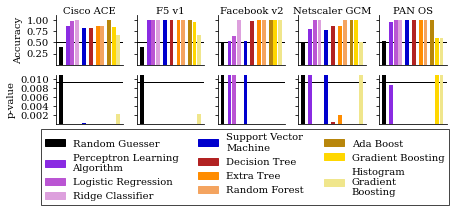

In [11]:
output_folder = os.path.join(os.getcwd(), 'results')

path = os.path.join(os.getcwd(), '2021-01-30-ciscoace', 'Model Results.csv')
dataframe_cisco = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-f5v1', 'Model Results.csv')
dataframe_f5 = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-02-01-facebookv2', 'Model Results.csv')
dataframe_facebook = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-netscalergcm', 'Model Results.csv')
dataframe_netscaler = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-panos', 'Model Results.csv')
dataframe_pan = pd.read_csv(path, index_col=0)
params = dict(loc='upper center', bbox_to_anchor=(-2.0, 0), ncol=3, fancybox=False, frameon=True,
                      shadow=False, facecolor='white', edgecolor='k')
bar_grid_for_dataset1(dataframe_cisco, 'Cisco ACE',
                     dataframe_f5, 'F5 v1',
                     dataframe_facebook, 'Facebook v2',
                     dataframe_netscaler, 'Netscaler GCM',
                     dataframe_pan, 'PAN OS',
                     os.path.join(output_folder, 'robot_accuracies.pgf'), params)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams

from matplotlib.patches import Patch
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline


def bar_grid_for_dataset1(dataframe_1, title_1, dataframe_2, title_2, dataframe_3, title_3, dataframe_4, title_4,
                         dataframe_5, title_5, output_filename, params):
    label1 = '0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02)'
    label2 = '0X00 In Pkcs#1 Padding (First 8 Bytes After 0X00 0X02) Missing-CCS-FIN'
    def trans(df, label):
        df['rank'] = df['Model'].map(custom_dict)
        df.sort_values(by=['Dataset', 'rank'], ascending=[True, True], inplace=True)
        del df['rank']
        df = df[~df['Model'].str.contains('SGD')]
        df = df[df.Dataset.eq(label)]
        return df
    dataframe_1_filtered = trans(dataframe_1, label1)
    dataframe_2_filtered = trans(dataframe_2, label2)
    dataframe_3_filtered = trans(dataframe_3, label2)
    dataframe_4_filtered = trans(dataframe_4, label1)
    dataframe_5_filtered = trans(dataframe_5, label1)
    u_models = list(dataframe_1_filtered.Model.unique())

    # Use serif font
    rcParams['font.family'] = 'serif'
    fontsize = 10
    rcParams['font.size'] = fontsize

    # Create two subplots
    fig, (axis_1, axis_2, axis_3, axis_4, axis_5) = plt.subplots(1, 5, figsize=(7, 1.4), sharey=True)

    # Calculate bar locations
    bar_x_positions = []
    bar_width = 0.5
    offset = 0.1
    space = 0.3
    bar_width_offset = bar_width + offset
    for i in [1, 3, 1, 1, 2, 3]:
        if len(bar_x_positions) == 0:
            bar_x_positions.extend(list(np.arange(1, i + 1) * bar_width_offset))
        else:
            ll = (bar_x_positions[-1] + space) + (np.arange(1, i + 1) * bar_width_offset)
            bar_x_positions.extend(ll)

    # Plot the data as bars
    axis_1.bar(x=bar_x_positions, height=dataframe_1_filtered.Accuracy, width=bar_width, color=colors, linewidth=0,
                  label=dataframe_1_filtered.Model)
    axis_2.bar(x=bar_x_positions, height=dataframe_2_filtered.Accuracy, width=bar_width, color=colors, linewidth=0)
    axis_3.bar(x=bar_x_positions, height=dataframe_3_filtered.Accuracy, width=bar_width, color=colors, linewidth=0)
    axis_4.bar(x=bar_x_positions, height=dataframe_4_filtered.Accuracy, width=bar_width, color=colors, linewidth=0)
    axis_5.bar(x=bar_x_positions, height=dataframe_5_filtered.Accuracy, width=bar_width, color=colors, linewidth=0)
    
    u_models = [model.split('Classifier')[0] for model in u_models]
    u_models[u_models.index('Perceptron')] = "PerceptronLearningAlgorithm"
    #u_models[u_models.index('SGD')] = "StochasticGradientDescent"
    u_models[u_models.index('LinearSVC')] = "SupportVectorMachine"
    u_models[u_models.index('Ridge')] = "RidgeClassifier"
    u_models[u_models.index('HistGradientBoosting')] = "HistogramGradientBoosting"
    u_models[0] = 'RandomGuesser'
    #u_models = [' '.join(re.findall('[A-Z][^A-Z]*', model)) for model in u_models]
    #u_models[u_models.index('Histogram Gradient Boosting')] = "Histogram\nGradient Boosting"
    #u_models[u_models.index('Stochastic Gradient Descent')] = "Stochastic Gradient\nDescent"
    #u_models[u_models.index('Support Vector Machine')] = "Support Vector\nMachine"
    u_models = [re.sub('[a-z]', '', model) for model in u_models]
    cmap = dict(zip(u_models, colors))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    params['fontsize']=fontsize
    plt.legend(handles=patches, **params)

    # Layout improvements
    fig.tight_layout()
    for ax in [axis_1, axis_2, axis_3, axis_4, axis_5]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        ax.axhline(0.5, color='black', linewidth=1, zorder=-1)
        end = 1.1
        step = 0.25
        round1 = 2
        ax.set_yticks(np.arange(0+step, end, step=step).round(round1))
        ax.set_ylim((0, 1.05))

    #ax.text(bar_x_positions[-1]+bar_width-0.1, 0.01-5e-4, s=r'$ \alpha $', fontsize=fontsize, color='darkgreen')
    axis_1.set_ylabel('Accuracy')

    for ax, title in zip([axis_1, axis_2, axis_3, axis_4, axis_5], [title_1, title_2, title_3, title_4, title_5]):
        #title = title.replace(' ', '\n')
        ax.set_title(title, fontsize=fontsize, y  = .91)
    # Save plot to file
    fig.savefig(output_filename, bbox_inches='tight')
    if 'png' in output_filename:
        fig.show()

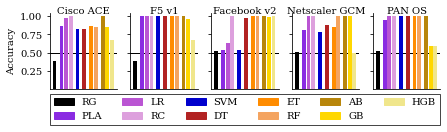

In [13]:
output_folder = os.path.join(os.getcwd(), 'results')

path = os.path.join(os.getcwd(), '2021-01-30-ciscoace', 'Model Results.csv')
dataframe_cisco = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-f5v1', 'Model Results.csv')
dataframe_f5 = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-02-01-facebookv2', 'Model Results.csv')
dataframe_facebook = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-netscalergcm', 'Model Results.csv')
dataframe_netscaler = pd.read_csv(path, index_col=0)
path = os.path.join(os.getcwd(), '2021-01-30-panos', 'Model Results.csv')
dataframe_pan = pd.read_csv(path, index_col=0)
params = dict(loc='upper center', bbox_to_anchor=(-1.9, 0), ncol=6, fancybox=False, frameon=True,
                      shadow=False, facecolor='white', edgecolor='k')
bar_grid_for_dataset1(dataframe_cisco, 'Cisco ACE',
                     dataframe_f5, 'F5 v1',
                     dataframe_facebook, 'Facebook v2',
                     dataframe_netscaler, 'Netscaler GCM',
                     dataframe_pan, 'PAN OS',
                     os.path.join(output_folder, 'robot_accuracies.pgf'), params)